In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_SIZE + (3, )


In [2]:
# With help of a tutorial I made this model, but apparently flow from directory is depraceted..
# Should've used image data from directory
train_dir = 'dataset/training'
test_dir = 'dataset/test'

train_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_set = train_data.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=IMG_SIZE)

validation_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

validation_set = validation_data.flow_from_directory(test_dir, shuffle=True, batch_size=32, class_mode='categorical', target_size=IMG_SIZE)


Found 5201 images belonging to 5 classes.
Found 1399 images belonging to 5 classes.


In [ ]:
# Get model

ResNet50 = tf.keras.applications.ResNet50(weights='imagenet', 
                                                include_top=False, 
                                                input_shape=IMG_SHAPE,
                                                classes=5)

In [ ]:
# Set layers to trainable
for layers in ResNet50.layers:
    layers.trainable=True

In [3]:
# Get optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.7, name="SGD")

# Create layers
x = tf.keras.layers.Flatten()(ResNet50.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
x = tf.keras.Model(inputs=ResNet50.input, outputs=x)
x.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

2022-06-28 20:24:26.479560: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
number_of_epochs = 10

resnetfile = 'resnet50'+'-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(resnetfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduceLearningRate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [checkpoint,earlyStopping,reduceLearningRate]
history = x.fit(train_generator, epochs = number_of_epochs, callbacks=callbacklist, validation_data = validation_generator, verbose=1)


Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.1483 - acc: 0.9700
Epoch 1: val_acc improved from -inf to 0.42816, saving model to resnet50-saved-model-01-val_acc-0.43.hdf5
163/163 [==============================] - 519s 3s/step - loss: 0.1483 - acc: 0.9700 - val_loss: 1.5414 - val_acc: 0.4282 - lr: 0.0100
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.0468 - acc: 0.9919
Epoch 2: val_acc did not improve from 0.42816
163/163 [==============================] - 669s 4s/step - loss: 0.0468 - acc: 0.9919 - val_loss: 3.6239 - val_acc: 0.1465 - lr: 0.0100
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.0181 - acc: 0.9948
Epoch 3: val_acc improved from 0.42816 to 0.42888, saving model to resnet50-saved-model-03-val_acc-0.43.hdf5
163/163 [==============================] - 657s 4s/step - loss: 0.0181 - acc: 0.9948 - val_loss: 2.3735 - val_acc: 0.4289 - lr: 0.0100
Epoch 4/10
163/163 [==============================] - ETA: 0s

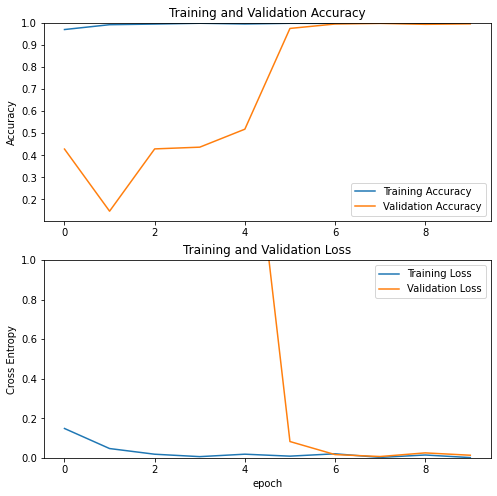

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [8]:
x.save('saved_model/resnet_model')

INFO:tensorflow:Assets written to: saved_model/resnet_model/assets
